In [3]:

import random
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
print(ROOT)

# ---- config ----
SEED = 1337

# Portrait Meta glasses frames
IMG_SIZE = (480, 640)   # (W, H)

OUT_STRIDE = 4
OUT_W = IMG_SIZE[0] // OUT_STRIDE
OUT_H = IMG_SIZE[1] // OUT_STRIDE

GAUSS_SIGMA = 2.5       # heatmap sigma at output resolution
BATCH_SIZE = 8
LR = 1e-4
NUM_EPOCHS = 30

# Single directory containing BOTH .png and .json
DATA_DIR = Path(ROOT / "data/gutter_regressor/new")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all()

print("DEVICE:", DEVICE)
print("DATA_DIR:", DATA_DIR)
print("Input size (W,H):", IMG_SIZE)
print("Output heatmap (W,H):", (OUT_W, OUT_H))


C:\Users\jleto\Projects\rev-vision
DEVICE: cuda
DATA_DIR: C:\Users\jleto\Projects\rev-vision\data\gutter_regressor\new
Input size (W,H): (480, 640)
Output heatmap (W,H): (120, 160)


In [2]:
# Cell — Dataset (lines + endpoints, no guessing)

import json
from pathlib import Path
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class GutterLineEndpointDataset(Dataset):
    def __init__(self, folder):
        self.folder = Path(folder)
        self.images = sorted(self.folder.glob("*.png"))
        assert len(self.images) > 0

    def __len__(self):
        return len(self.images)

    def _gaussian(self, cx, cy, h, w, sigma=3):
        yy, xx = np.mgrid[0:h, 0:w]
        return np.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2)).astype(np.float32)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        json_path = img_path.with_suffix(".json")

        img_bgr = cv2.imread(str(img_path))
        h0, w0 = img_bgr.shape[:2]

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, IMG_SIZE)
        img = torch.from_numpy(img_rgb / 255.0).permute(2, 0, 1).float()

        with open(json_path) as f:
            data = json.load(f)

        sx = IMG_SIZE[0] / data["imageWidth"]
        sy = IMG_SIZE[1] / data["imageHeight"]

        line_hm = np.zeros((2, IMG_SIZE[1], IMG_SIZE[0]), np.float32)
        pt_hm   = np.zeros((4, IMG_SIZE[1], IMG_SIZE[0]), np.float32)

        for s in data["shapes"]:
            if s["shape_type"] != "line":
                continue

            label = s["label"].lower()
            (x1, y1), (x2, y2) = s["points"]

            p1 = (int(x1 * sx), int(y1 * sy))
            p2 = (int(x2 * sx), int(y2 * sy))

            if label == "left":
                li = 0
                pi = 0
            elif label == "right":
                li = 1
                pi = 2
            else:
                continue

            cv2.line(line_hm[li], p1, p2, 1.0, thickness=2, lineType=cv2.LINE_AA)
            pt_hm[pi]   = self._gaussian(*p1, IMG_SIZE[1], IMG_SIZE[0])
            pt_hm[pi+1] = self._gaussian(*p2, IMG_SIZE[1], IMG_SIZE[0])

        line_hm = torch.from_numpy(np.clip(line_hm, 0, 1))
        pt_hm   = torch.from_numpy(np.clip(pt_hm, 0, 1))

        return img, line_hm, pt_hm


In [1]:
# Cell — Model (line + endpoint heads)

import torch.nn as nn

class GutterNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
        )

        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
        )

        self.line_head = nn.Conv2d(32, 2, 1)
        self.pt_head   = nn.Conv2d(32, 4, 1)

    def forward(self, x):
        f = self.up(self.encoder(x))
        return self.line_head(f), self.pt_head(f)


In [ ]:
# Cell — Model (line-first, learned endpoint readout)

class GutterNet(nn.Module):
    def __init__(self):
        super().__init__()

        # backbone (unchanged)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
        )

        # primary output
        self.line_head = nn.Conv2d(32, 2, 1)

        # endpoint readout (consumes line heatmaps, NOT raw features)
        self.endpoint_head = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 4, 1)  # Ls, Le, Rs, Re
        )

    def forward(self, x):
        f = self.decoder(self.encoder(x))
        line_logits = self.line_head(f)

        # IMPORTANT: endpoint head reads from line prediction
        endpoint_logits = self.endpoint_head(torch.sigmoid(line_logits))

        return line_logits, endpoint_logits


In [ ]:
# Cell — Training (line → endpoint)
# Cell — Model init

model = GutterNet().to(DEVICE)

opt = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

print("Model initialized and moved to", DEVICE)

bce = nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    total = 0

    for img, line_gt, pt_gt in dl:
        img = img.to(DEVICE)
        line_gt = line_gt.to(DEVICE)
        pt_gt = pt_gt.to(DEVICE)

        opt.zero_grad()
        line_pred, pt_pred = model(img)

        loss_line = bce(line_pred, line_gt)
        loss_pts  = bce(pt_pred, pt_gt)

        loss = loss_line + 1.5 * loss_pts
        loss.backward()
        opt.step()

        total += loss.item()

    print(f"Epoch {epoch+1}: {total/len(dl):.4f}")


Epoch 1: 2.0998
Epoch 2: 2.0484
Epoch 3: 1.4853
Epoch 4: 0.5457
Epoch 5: 0.0503
Epoch 6: 0.0421
Epoch 7: 0.0398
Epoch 8: 0.0373
Epoch 9: 0.0334
Epoch 10: 0.0317
Epoch 11: 0.0293
Epoch 12: 0.0268
Epoch 13: 0.0252
Epoch 14: 0.0236
Epoch 15: 0.0233
Epoch 16: 0.0220
Epoch 17: 0.0198
Epoch 18: 0.0201
Epoch 19: 0.0195
Epoch 20: 0.0190
Epoch 21: 0.0189
Epoch 22: 0.0184
Epoch 23: 0.0176
Epoch 24: 0.0153
Epoch 25: 0.0152
Epoch 26: 0.0141
Epoch 27: 0.0133
Epoch 28: 0.0125
Epoch 29: 0.0113
Epoch 30: 0.0105


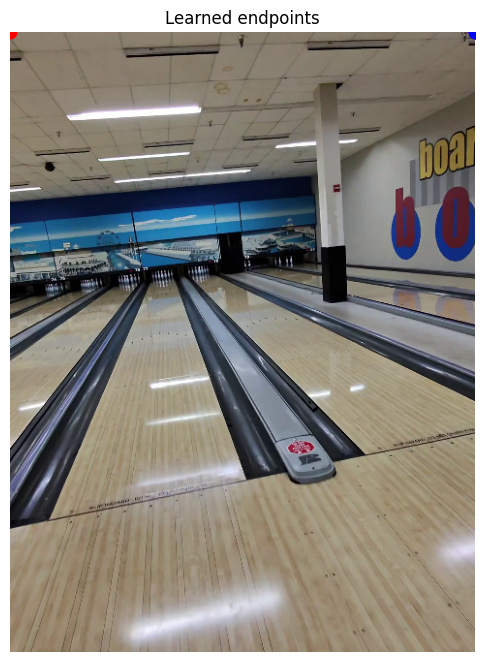

In [8]:
# Cell — Endpoint inference (learned)

model.eval()
img, _, _ = ds[np.random.randint(len(ds))]

with torch.no_grad():
    _, pt_pred = model(img.unsqueeze(0).to(DEVICE))
    pt_pred = torch.sigmoid(pt_pred)[0].cpu().numpy()

img_np = img.permute(1,2,0).numpy()

plt.figure(figsize=(6,10))
plt.imshow(img_np)

colors = ["red","red","blue","blue"]
for i in range(4):
    y, x = np.unravel_index(np.argmax(pt_pred[i]), pt_pred[i].shape)
    plt.scatter(x, y, c=colors[i], s=80)

plt.axis("off")
plt.title("Learned endpoints")
plt.show()
